In [2]:
using Distributions
using Rocket
using ReactiveMP
using BenchmarkTools
using Plots
using Random
using GraphPPL

import ProgressMeter

┌ Info: Precompiling GraphPPL [b3f8163a-e979-4e85-b43e-1f63d8c8b42c]
└ @ Base loading.jl:1278
┌ Warning: Package GraphPPL does not have ReactiveMP in its dependencies:
│ - If you have GraphPPL checked out for development and have
│   added ReactiveMP as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with GraphPPL
└ Loading ReactiveMP into GraphPPL from project dependency, future warnings for GraphPPL are suppressed.


In [89]:
@model function multivariate_hgf_model(n, z_precision, kfunction, approximation)
    
    zt = randomvar(n)
    xt = randomvar(n)
    yt = datavar(Vector{Float64}, n)
    
    # Priors
    zt_1_mean = datavar(Vector{Float64})
    zt_1_prec = datavar(Matrix{Float64})
    
    xt_1_mean = datavar(Vector{Float64})
    xt_1_prec = datavar(Matrix{Float64})
    
    y_prec_ν = datavar(Float64)
    y_prec_S = datavar(Matrix{Float64})
    
    zt_1_prior ~ MvNormalMeanPrecision(zt_1_mean, zt_1_prec)
    xt_1_prior ~ MvNormalMeanPrecision(xt_1_mean, xt_1_prec)
    y_prec_prior ~ Wishart(y_prec_ν, y_prec_S)
    
    mz = Vector{Marginal}(undef, n)
    mx = Vector{Marginal}(undef, n)
    mz_subs      = Vector{Teardown}(undef, n)
    mx_subs      = Vector{Teardown}(undef, n)
    ms_scheduler = PendingScheduler()
    
    zt[1] = zt_1_prior
    xt[1] = xt_1_prior
    
    zt_nodes = Vector{FactorNode}(undef, n - 1)
    xt_nodes = Vector{FactorNode}(undef, n - 1)
    yt_nodes = Vector{FactorNode}(undef, n - 1)
    
    mx_subs[1] = subscribe!(getmarginal(xt[1]) |> schedule_on(ms_scheduler), (m) -> mx[1] = m)
    mz_subs[1] = subscribe!(getmarginal(zt[1]) |> schedule_on(ms_scheduler), (m) -> mz[1] = m)
    
    for i in 2:n
        zt_nodes[i - 1], zt[i] ~ MvNormalMeanPrecision(zt[i - 1], z_precision) where { q = q(zt[i - 1], zt[i])q(z_precision) }
        xt_nodes[i - 1], xt[i] ~ KernelGCV(xt[i - 1], zt[i]) where { q = q(xt[i - 1], xt[i])q(zt[i]), meta = KernelGCVMetadata(kfunction, approximation) }
        yt_nodes[i - 1], yt[i] ~ MvNormalMeanPrecision(xt[i], y_prec_prior) where { q = MeanField() }
        
        mx_subs[i] = subscribe!(getmarginal(xt[i]) |> schedule_on(ms_scheduler), (m) -> mx[i] = m)
        mz_subs[i] = subscribe!(getmarginal(zt[i]) |> schedule_on(ms_scheduler), (m) -> mz[i] = m)
    end

    return zt_1_mean, zt_1_prec, xt_1_mean, xt_1_prec, y_prec_ν, y_prec_S, y_prec_prior, zt, xt, yt, zt_nodes, xt_nodes, yt_nodes, mz, mx, mz_subs, mx_subs, ms_scheduler
end

multivariate_hgf_model (generic function with 1 method)

In [90]:
function inference(; data, iters, z_precision, kfunction, approximation)
    n    = length(data)
    ndim = length(data[1])
    
    zt_1_mean, zt_1_prec, xt_1_mean, xt_1_prec, y_prec_ν, y_prec_S, y_prec_prior, zt, xt, yt, zt_nodes, xt_nodes, yt_nodes, mz, mx, mz_subs, mx_subs, ms_scheduler = multivariate_hgf_model(n, z_precision, kfunction, approximation)
    
    Vsub = subscribe!(getmarginal(y_prec_prior), (V) -> push!(mV, V))
    
    # Initial marginals
    foreach(zt_nodes) do zt_node
        setmarginal!(zt_node, :out_μ, MvNormalMeanPrecision(zeros(2ndim), Matrix(Diagonal(1.0 * ones(2ndim)))))
    end
    
    foreach(xt_nodes) do xt_node
        setmarginal!(xt_node, :y_x, MvNormalMeanPrecision(zeros(2ndim), Matrix(Diagonal(1.0 * ones(2ndim)))))
        setmarginal!(xt_node, :z, MvNormalMeanPrecision(zeros(ndim), Matrix(Diagonal(1.0 * ones(ndim)))))
    end
    
    foreach(yt_nodes) do yt_node
        setmarginal!(yt_node, :μ, MvNormalMeanPrecision(zeros(ndim), Matrix(Diagonal(1.0 * ones(ndim)))))
    end
    
    setmarginal!(y_prec_prior, Wishart(ndim, 100.0 * Matrix(I, ndim, ndim)))
    
    # Initial messages
    prior_zt = MvNormalMeanPrecision(zeros(ndim), Matrix(Diagonal(100.0 * ones(ndim))))
    prior_xt = MvNormalMeanPrecision(zeros(ndim), Matrix(Diagonal(100.0 * ones(ndim))))
    prior_V  = Wishart(ndim, 100.0 * Matrix(I, ndim, ndim))
    
    progress = ProgressMeter.Progress(iters)

    for _ in 1:iters
        
        for i in 1:n
            update!(yt[i], data[i])
        end
        
        update!(y_prec_ν, prior_V.df)
        update!(y_prec_S, Matrix(prior_V.S))
        update!(xt_1_mean, mean(prior_xt))
        update!(xt_1_prec, precision(prior_xt))
        update!(zt_1_mean, mean(prior_zt))
        update!(zt_1_prec, precision(prior_zt))
        
        ProgressMeter.next!(progress)
    end
    
    release!(ms_scheduler)
    
    foreach(unsubscribe!, mz_subs)
    foreach(unsubscribe!, mx_subs)
    unsubscribe!(Vsub)
    
    return mz, mx, mV
end

inference (generic function with 1 method)

In [91]:
import ReactiveMP: @rule, @marginalrule, score

@rule(
    formtype => Type{ <: MvNormalMeanPrecision },
    on   => :μ,
    vconstraint => Marginalisation,
    messages => (m_out::ReactiveMP.FnWithApproximation, ),
    marginals => (q_Λ::Dirac, ),
    meta => Nothing,
    begin
        vindex = ReactiveMP.varindex(__node, :μ)
        vin    = @inbounds ReactiveMP.variables(__node)[vindex]
        return vin.m_in |> take(1) |> map(MvNormalMeanPrecision, (m_μ) -> begin
            inv_q_Λ        = cholinv(mean(q_Λ))
            msg_fwd        = MvNormalMeanPrecision(mean(m_μ), cholinv(cov(m_μ) + inv_q_Λ))
            multiplication = getdata(as_message(msg_fwd) * as_message(m_out))
            
            m, c = mean(multiplication), cov(multiplication)
            return MvNormalMeanPrecision(m, cholinv(c + inv_q_Λ))
        end)
    end
)

@marginalrule(
    formtype => Type{ <: MvNormalMeanPrecision },
    on   => :out_μ,
    messages => (m_out::ReactiveMP.FnWithApproximation, m_μ::MvNormalMeanPrecision),
    marginals => (q_Λ::Dirac, ),
    meta => Nothing,
    begin
        d = ndims(m_μ)
        
        m_mean_mean, m_mean_cov = mean(m_μ), cov(m_μ)
        
        Wbar = mean(q_Λ)
        
        W = [ Wbar -Wbar; -Wbar Wbar ]

        logpdf = m_out.fn

        msg_fwd    = MvNormalMeanPrecision(mean(m_μ), cholinv(cov(m_μ) + cholinv(mean(q_Λ))))
        v_mean_inv = precision(m_μ)

        l(z) = @views -0.5 * z'*W*z - 0.5 * (z[d+1:end] - m_mean_mean)' * v_mean_inv * (z[d+1:end] - m_mean_mean) + logpdf(z[1:d])

        #Expansion point
        point1 = mean(as_message(msg_fwd) * as_message(m_out))

        try
            m_joint, v_joint = ForneyLab.NewtonMethod(l, [ point1; m_mean_mean ])
            return MvNormalMeanPrecision(m_joint, cholinv(v_joint))
        catch e
            # Use cubature as a fallback
            cubature = m_out.approximation
            mean, cov = ReactiveMP.approximate_meancov(cubature, (x) -> exp(logpdf(x)), msg_fwd)
            
            approx_prec = Matrix(Hermitian([ cholinv(cov) + Wbar -Wbar; -Wbar cholinv(m_mean_cov) + Wbar ]))
            approx_mean = cholinv(approx_prec) * [ cholinv(cov) * mean; cholinv(m_mean_cov) * m_mean_mean ]
            
            return MvNormalMeanPrecision(approx_mean, approx_prec)
        end
    end
)

function ReactiveMP.score(::AverageEnergy, ::Type{ <: KernelGCV }, marginal_names, marginals::Tuple{ <: Marginal{ <: MvNormalMeanPrecision }, <: Marginal{ <: MvNormalMeanPrecision } }, meta::KernelGCVMetadata)
    marg_out_mean = marginals[1]
    marg_z        = marginals[2]
    
    (m, V) = mean(marg_out_mean), cov(marg_out_mean)
    (mz,Vz) = mean(marg_z), cov(marg_z)

    d = Int64(ndims(marg_out_mean) / 2)

    cubature = ReactiveMP.get_approximation(meta)
    weights = ReactiveMP.getweights(cubature, mz, Vz)
    points  = ReactiveMP.getpoints(cubature, mz, Vz)
    
    kernelfn = ReactiveMP.get_kernelfn(meta)

    gs = Base.Generator(points) do point
        return kernelfn(point)
    end

    Λ_out = mapreduce(t -> t[1] * cholinv(t[2]), +, zip(weights, gs))
    log_det_sum = mapreduce(t -> t[1] * log(det(t[2])), +, zip(weights, gs))

    @views 0.5*d*log(2*pi) +
    0.5*log_det_sum +
    0.5*tr( Λ_out*( V[1:d,1:d] - V[1:d,d+1:end] - V[d+1:end,1:d] + V[d+1:end,d+1:end] + (m[1:d] - m[d+1:end])*(m[1:d] - m[d+1:end])' ) )
end

In [67]:
using KernelFunctions

In [68]:
ndim     = 4

4

In [69]:
kfunction = (d) -> kernelmatrix(LinearKernel(c = 1.0), d) + Diagonal(1.0 * ones(ndim)) + 0.5 * Diagonal(exp.(d))

#200 (generic function with 1 method)

In [87]:
using Random
using Distributions
using LinearAlgebra

n     = 250
iters = 100

approximation = srcubature()

Random.seed!(2211)

z_prev = zeros(ndim)
x_prev = zeros(ndim)

z_covariance = Matrix(Diagonal(0.010 * ones(ndim)))
y_variance   = 0.001 * ones(ndim)
y_covariance = Matrix(Diagonal(y_variance))

z = Vector{Vector{Float64}}(undef, n)
v = Vector{Matrix{Float64}}(undef, n)
x = Vector{Vector{Float64}}(undef, n)
y = Vector{Vector{Float64}}(undef, n)

for i in 1:n
    z[i] = rand(MvNormal(z_prev, Matrix(z_covariance)))
    v[i] = kfunction(z[i])
    x[i] = rand(MvNormal(x_prev, v[i]))
    y[i] = rand(MvNormal(x[i], Matrix(y_covariance)))
    z_prev = z[i]
    x_prev = x[i]
end

In [92]:
mz, mx, mV = inference(; 
    data = y, 
    iters = iters, 
    z_precision = inv(z_covariance), 
    kfunction = kfunction, 
    approximation = approximation
);

LoadError: UndefVarError: i not defined

In [83]:
gr()

function plot_dimension(mz, mx, ys, dim = 1)
    p1 = plot(map(d -> d[dim], mean.(mz)), ribbon = map(d -> sqrt(d[dim]), var.(mz)), label = :z)
    p1 = plot!(p1, map(d -> d[dim], z), label = :real_z)

    p2 = plot(map(d -> d[dim], mean.(mx)), ribbon = map(d -> sqrt(d[dim]), var.(mx)), label = :x)
    p2 = plot!(p2, map(d -> d[dim], x), label = :real_x)
    p2 = scatter!(map(d -> d[dim], ys), ms = 2)
    
    ex = map(d -> d[dim], mean.(mx))
    ex_min, ex_max = minimum(ex[80:130]), maximum(ex[80:130])
    
    p2 = lens!(p2, [ 80, 130 ], [ ex_min, ex_max ], inset = (1, bbox(0.5, 0.0, 0.4, 0.4)))
    

    plot(p1, p2, layout = (1, 2), size = (1200, 200), legend = false)
end

plot_dimension (generic function with 2 methods)

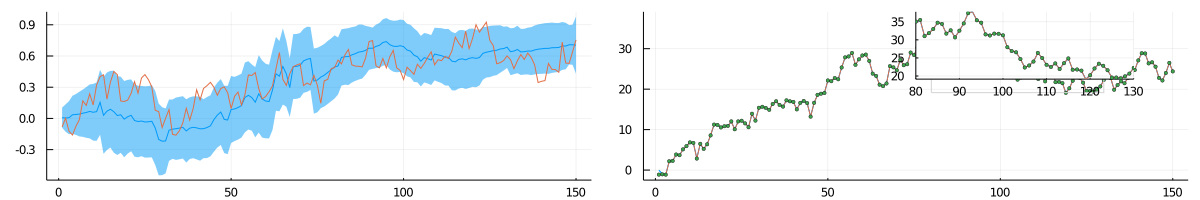

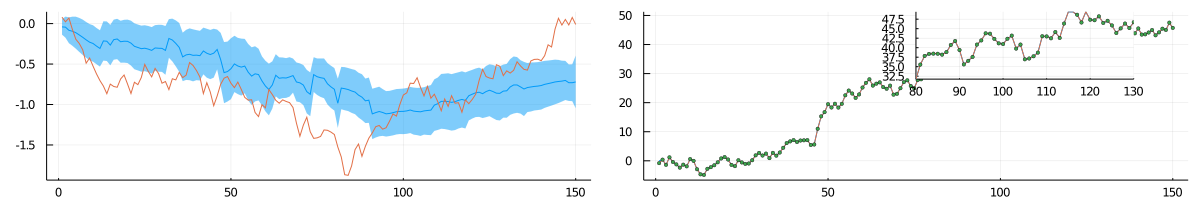

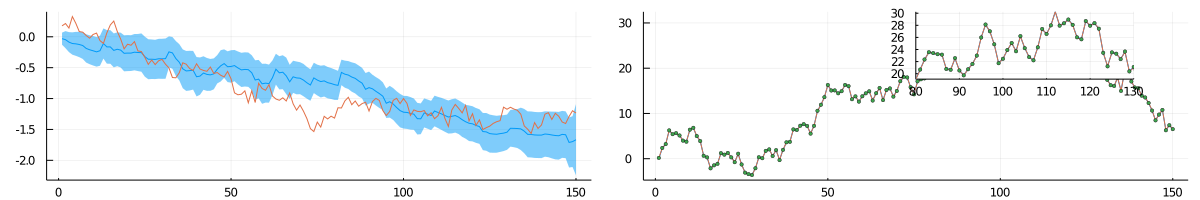

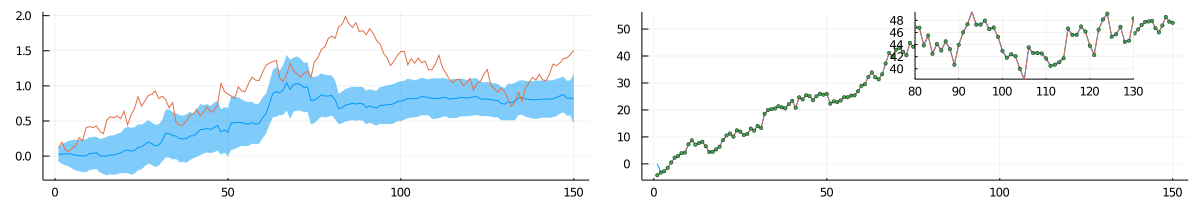

In [84]:
for i in 1:ndim
    display(plot_dimension(mz, mx, y, i))
end